# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Our task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

We are given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

We'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, we wouldn't want to send a buy 10 dollars get 2 dollars off offer. We'll want to try to assess what a certain demographic group will buy when not receiving any offers.

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record


In [61]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
import json
% matplotlib inline

from datetime import datetime

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

# Exploring Data

In [2]:
portfolio.head()

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5


In [3]:
portfolio.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 6 columns):
channels      10 non-null object
difficulty    10 non-null int64
duration      10 non-null int64
id            10 non-null object
offer_type    10 non-null object
reward        10 non-null int64
dtypes: int64(3), object(3)
memory usage: 560.0+ bytes


In [4]:
portfolio.describe()

,difficulty,duration,reward
count,10.000000,10.000000,10.000000
mean,7.700000,6.500000,4.200000
std,5.831905,2.321398,3.583915
min,0.000000,3.000000,0.000000
25%,5.000000,5.000000,2.000000
50%,8.500000,7.000000,4.000000
75%,10.000000,7.000000,5.000000
max,20.000000,10.000000,10.000000


In [5]:
profile.head()

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN


In [6]:
profile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
age                 17000 non-null int64
became_member_on    17000 non-null int64
gender              14825 non-null object
id                  17000 non-null object
income              14825 non-null float64
dtypes: float64(1), int64(2), object(2)
memory usage: 664.1+ KB


In [7]:
profile.describe()

,age,became_member_on,income
count,17000.000000,1.700000e+04,14825.000000
mean,62.531412,2.016703e+07,65404.991568
std,26.738580,1.167750e+04,21598.299410
min,18.000000,2.013073e+07,30000.000000
25%,45.000000,2.016053e+07,49000.000000
50%,58.000000,2.017080e+07,64000.000000
75%,73.000000,2.017123e+07,80000.000000
max,118.000000,2.018073e+07,120000.000000


In [8]:
transcript.head()

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


In [9]:
transcript.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 4 columns):
event     306534 non-null object
person    306534 non-null object
time      306534 non-null int64
value     306534 non-null object
dtypes: int64(1), object(3)
memory usage: 9.4+ MB


In [10]:
transcript.describe()

,time
count,306534.000000
mean,366.382940
std,200.326314
min,0.000000
25%,186.000000
50%,408.000000
75%,528.000000
max,714.000000


# Exploratory Data Visualization

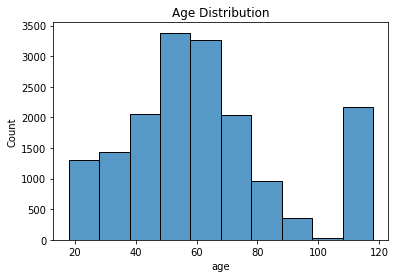

In [11]:
# explore age distribution
sns.histplot(profile['age'], bins = 10).set_title('Age Distribution');

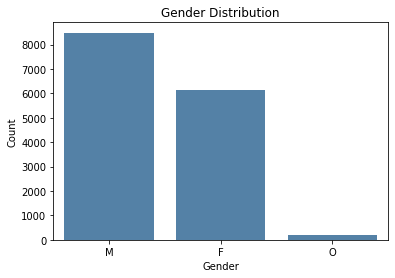

In [12]:
# explore gender distribution
sns.barplot(x = profile['gender'].value_counts().index, y = profile['gender'].value_counts(), color = 'steelblue').set(xlabel='Gender', ylabel='Count', title='Gender Distribution');

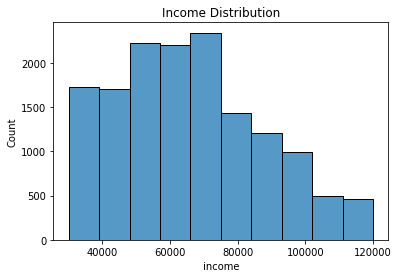

In [13]:
# explore income distribution
sns.histplot(profile['income'], bins = 10).set_title('Income Distribution');

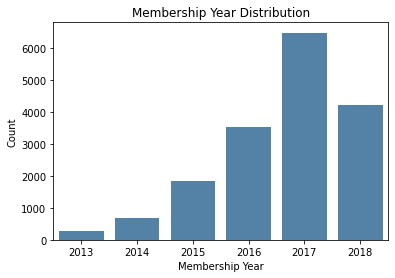

In [14]:
# explore membership year distribution
y = profile.groupby(profile['became_member_on'].apply(lambda x: str(x)[:4]))['id'].count() 
sns.barplot(x = y.index, y = y.values, color = 'steelblue').set(xlabel='Membership Year', ylabel='Count', title='Membership Year Distribution');

# Data Cleaning and Processing

In [15]:
# Copy the original dataframes into working ones to clean and act on

pro = profile.copy()
port = portfolio.copy()
trans = transcript.copy()

## Clean the portfolio dataframe

In [16]:
# rename the id column to be more unique and informative
port.rename(columns = {'id': 'offer_id'}, inplace = True)

In [17]:
# Convert the channels column in protfolio into 4 different columns based on the channel type

if 'channels' in port: # temporary until I finish coding and running
    port['web'] = port['channels'].apply(lambda x: 1 if 'web' in x else 0)
    port['email'] = port['channels'].apply(lambda x: 1 if 'email' in x else 0)
    port['mobile'] = port['channels'].apply(lambda x: 1 if 'mobile' in x else 0)
    port['social'] = port['channels'].apply(lambda x: 1 if 'social' in x else 0)

    port.drop('channels', axis = 1, inplace = True)

In [18]:
# Map the offer_type to integer values
port['offer_type'] = port['offer_type'].astype('category')
print(port['offer_type'].cat.categories)
port['offer_type'] = port['offer_type'].cat.codes

Index(['bogo', 'discount', 'informational'], dtype='object')


In [19]:
port.head()

,difficulty,duration,offer_id,offer_type,reward,web,email,mobile,social
0,10,7,ae264e3637204a6fb9bb56bc8210ddfd,0,10,0,1,1,1
1,10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,0,10,1,1,1,1
2,0,4,3f207df678b143eea3cee63160fa8bed,2,0,1,1,1,0
3,5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,0,5,1,1,1,0
4,20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,5,1,1,0,0


## Clean the profile dataframe

In [20]:
# rename the id column to be more unique and facilitate the merge later
pro.rename(columns = {'id': 'user_id'}, inplace = True)

In [21]:
# drop the outliers in the age column
pro = pro[pro['age'] < 105]

In [22]:
pro.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14825 entries, 1 to 16999
Data columns (total 5 columns):
age                 14825 non-null int64
became_member_on    14825 non-null int64
gender              14825 non-null object
user_id             14825 non-null object
income              14825 non-null float64
dtypes: float64(1), int64(2), object(2)
memory usage: 694.9+ KB


In [23]:
# Map gender to integer values
pro['gender'] = pro['gender'].astype('category')
print(pro['gender'].cat.categories)
pro['gender'] = pro['gender'].cat.codes

Index(['F', 'M', 'O'], dtype='object')


In [24]:
# replace the became_member_on column to the member_duration column that represent how long the user has been a member

pro['member_duration'] = (datetime.today().date() - pd.to_datetime(pro['became_member_on'], format='%Y%m%d').dt.date).dt.days
pro.drop('became_member_on', axis = 1, inplace = True)

In [25]:
pro.head()

,age,gender,user_id,income,member_duration
1,55,0,0610b486422d4921ae7d2bf64640c50b,112000.0,1468
3,75,0,78afa995795e4d85b5d9ceeca43f5fef,100000.0,1535
5,68,1,e2127556f4f64592b11af22de27a7932,70000.0,1183
8,65,1,389bc3fa690240e798340f5a15918d5c,53000.0,1259
12,58,1,2eeac8d8feae4a8cad5a6af0499a211d,51000.0,1349


## Clean the transcript dataframe

In [29]:
trans['value']

0          {'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1          {'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2          {'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3          {'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4          {'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}
5          {'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'}
6          {'offer id': '2298d6c36e964ae4a3e7e9706d1fb8c2'}
7          {'offer id': '3f207df678b143eea3cee63160fa8bed'}
8          {'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
9          {'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
10         {'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
11         {'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
12         {'offer id': 'ae264e3637204a6fb9bb56bc8210ddfd'}
13         {'offer id': '3f207df678b143eea3cee63160fa8bed'}
14         {'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
15         {'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
16         {'offer id': '0b1e1539f2cc45b

In [30]:
# breakdown the value column into offer_id and amount columns then drop it

trans['offer_id'] = trans['value'].apply(lambda x: x['offer id'] if ('offer id' in x) else x['offer_id'] if ('offer_id' in x) else None)
trans['amount'] = trans['value'].apply(lambda x: x['amount'] if ('amount' in x) else None)

trans.drop('value', axis = 1, inplace = True)


In [31]:
# rename the person column to user_id
trans.rename(columns = {'person': 'user_id'}, inplace = True)

In [32]:
trans.head()

,event,user_id,time,offer_id,amount
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN
2,offer received,e2127556f4f64592b11af22de27a7932,0,2906b810c7d4411798c6938adc9daaa5,NaN
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,fafdcd668e3743c1bb461111dcafc2a4,NaN
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN


## Merging all the cleaned dataframes into one

In [33]:
# merge the transcript and profile dataframes
df = trans.merge(pro, on='user_id')

# merge with the portfolio dataframe
df = df.merge(port, how='left', on='offer_id')

In [34]:
df.head()

,event,user_id,time,offer_id,amount,age,gender,income,member_duration,difficulty,duration,offer_type,reward,web,email,mobile,social
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,75,0,100000.0,1535,5.0,7.0,0.0,5.0,1.0,1.0,1.0,0.0
1,offer viewed,78afa995795e4d85b5d9ceeca43f5fef,6,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,75,0,100000.0,1535,5.0,7.0,0.0,5.0,1.0,1.0,1.0,0.0
2,transaction,78afa995795e4d85b5d9ceeca43f5fef,132,None,19.89,75,0,100000.0,1535,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,offer completed,78afa995795e4d85b5d9ceeca43f5fef,132,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,75,0,100000.0,1535,5.0,7.0,0.0,5.0,1.0,1.0,1.0,0.0
4,transaction,78afa995795e4d85b5d9ceeca43f5fef,144,None,17.78,75,0,100000.0,1535,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Continued Exploration of Data

In [35]:
df[df['event'] == 'offer completed']['offer_type'].value_counts()

1.0    17186
0.0    15258
Name: offer_type, dtype: int64

In [36]:
df['offer_type'].value_counts()

0.0    63834
1.0    62311
2.0    22660
Name: offer_type, dtype: int64

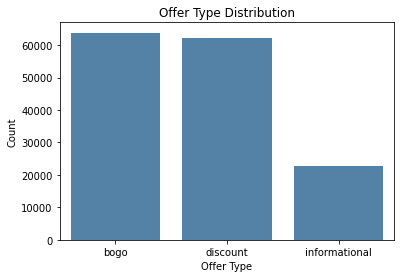

In [37]:
# explore offer type distribution
sns.barplot(x = ['bogo', 'discount', 'informational'], y = df['offer_type'].value_counts(), color = 'steelblue').set(xlabel='Offer Type', ylabel='Count', title='Offer Type Distribution') ;


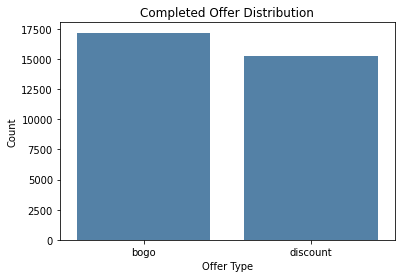

In [38]:
# explore completed offers distribution
sns.barplot(x=['bogo', 'discount'], y = df[df['event'] == 'offer completed']['offer_type'].value_counts(), color = 'steelblue').set(xlabel='Offer Type', ylabel='Count', title='Completed Offer Distribution');


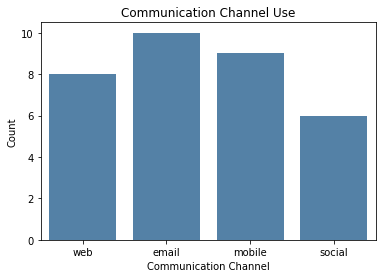

In [39]:
y = port[['web', 'email', 'mobile', 'social']].sum()
sns.barplot(x = ['web', 'email', 'mobile', 'social'], y = y, color = 'steelblue').set(xlabel='Communication Channel', ylabel='Count', title='Communication Channel Use');

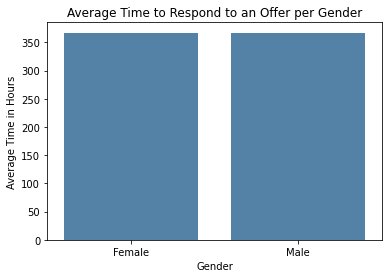

In [40]:
y = df.groupby('gender')['time'].mean()[:2]
sns.barplot(x = ['Female', 'Male'], y = y, color = 'steelblue').set(xlabel='Gender', ylabel='Average Time in Hours', title='Average Time to Respond to an Offer per Gender');

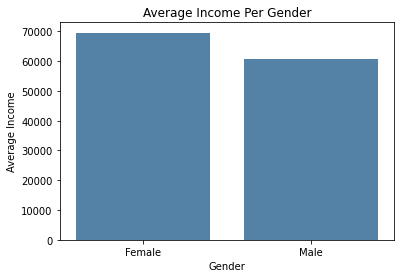

In [41]:
y = df.groupby('gender')['income'].mean()[:2]
sns.barplot(x = ['Female', 'Male'], y = y, color = 'steelblue').set(xlabel='Gender', ylabel='Average Income', title='Average Income Per Gender');

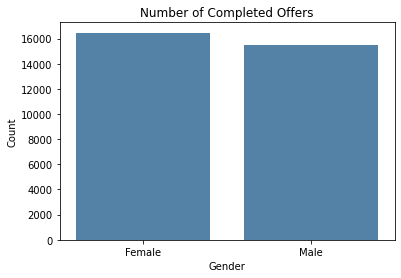

In [42]:
# who is more likely to complete an offer; female vs. male
sns.barplot(x = ['Female', 'Male'], y = df[df['event'] == 'offer completed']['gender'].value_counts()[:2], color = 'steelblue').set(xlabel='Gender', ylabel='Count', title='Number of Completed Offers') ;

# Data Modeling

## The target of our data modeling stage is to predict whether or not someone will respond to (i.e., complete) an offer or only view it

In [43]:
# make a copy of the original dataframe for final processing before modeling
data = df.copy() 

In [44]:
# Converting offer_id values into integer values
data['offer_id'] = data['offer_id'].astype('category')
data['offer_id'] = data['offer_id'].cat.codes

In [45]:
data.head()

,event,user_id,time,offer_id,amount,age,gender,income,member_duration,difficulty,duration,offer_type,reward,web,email,mobile,social
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,6,NaN,75,0,100000.0,1535,5.0,7.0,0.0,5.0,1.0,1.0,1.0,0.0
1,offer viewed,78afa995795e4d85b5d9ceeca43f5fef,6,6,NaN,75,0,100000.0,1535,5.0,7.0,0.0,5.0,1.0,1.0,1.0,0.0
2,transaction,78afa995795e4d85b5d9ceeca43f5fef,132,-1,19.89,75,0,100000.0,1535,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,offer completed,78afa995795e4d85b5d9ceeca43f5fef,132,6,NaN,75,0,100000.0,1535,5.0,7.0,0.0,5.0,1.0,1.0,1.0,0.0
4,transaction,78afa995795e4d85b5d9ceeca43f5fef,144,-1,17.78,75,0,100000.0,1535,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [46]:
# Keep only records with either offer viewed or completed
data = data[(data['event'] != 'offer received') & (data['event'] != 'transaction')]

In [47]:
# Map the events to integer values
data['event'] = data['event'].astype('category')
print(data['event'].cat.categories)
data['event'] = data['event'].cat.codes

Index(['offer completed', 'offer viewed'], dtype='object')


In [48]:
data.head()

,event,user_id,time,offer_id,amount,age,gender,income,member_duration,difficulty,duration,offer_type,reward,web,email,mobile,social
1,1,78afa995795e4d85b5d9ceeca43f5fef,6,6,NaN,75,0,100000.0,1535,5.0,7.0,0.0,5.0,1.0,1.0,1.0,0.0
3,0,78afa995795e4d85b5d9ceeca43f5fef,132,6,NaN,75,0,100000.0,1535,5.0,7.0,0.0,5.0,1.0,1.0,1.0,0.0
6,1,78afa995795e4d85b5d9ceeca43f5fef,216,5,NaN,75,0,100000.0,1535,0.0,3.0,2.0,0.0,0.0,1.0,1.0,1.0
11,1,78afa995795e4d85b5d9ceeca43f5fef,408,7,NaN,75,0,100000.0,1535,10.0,7.0,0.0,10.0,0.0,1.0,1.0,1.0
14,0,78afa995795e4d85b5d9ceeca43f5fef,510,7,NaN,75,0,100000.0,1535,10.0,7.0,0.0,10.0,0.0,1.0,1.0,1.0


In [49]:
# Normalize the big value numerical columns

scaler = MinMaxScaler()
n_col = ['time', 'age', 'income', 'difficulty', 'duration', 'reward']
data[n_col] = scaler.fit_transform(data[n_col])

data.head()

,event,user_id,time,offer_id,amount,age,gender,income,member_duration,difficulty,duration,offer_type,reward,web,email,mobile,social
1,1,78afa995795e4d85b5d9ceeca43f5fef,0.008403,6,NaN,0.686747,0,0.777778,1535,0.25,0.571429,0.0,0.5,1.0,1.0,1.0,0.0
3,0,78afa995795e4d85b5d9ceeca43f5fef,0.184874,6,NaN,0.686747,0,0.777778,1535,0.25,0.571429,0.0,0.5,1.0,1.0,1.0,0.0
6,1,78afa995795e4d85b5d9ceeca43f5fef,0.302521,5,NaN,0.686747,0,0.777778,1535,0.00,0.000000,2.0,0.0,0.0,1.0,1.0,1.0
11,1,78afa995795e4d85b5d9ceeca43f5fef,0.571429,7,NaN,0.686747,0,0.777778,1535,0.50,0.571429,0.0,1.0,0.0,1.0,1.0,1.0
14,0,78afa995795e4d85b5d9ceeca43f5fef,0.714286,7,NaN,0.686747,0,0.777778,1535,0.50,0.571429,0.0,1.0,0.0,1.0,1.0,1.0


In [50]:
# Checking if our dataframe has NaN values
data.isnull().sum()

event                  0
user_id                0
time                   0
offer_id               0
amount             82304
age                    0
gender                 0
income                 0
member_duration        0
difficulty             0
duration               0
offer_type             0
reward                 0
web                    0
email                  0
mobile                 0
social                 0
dtype: int64

In [51]:
# Filling NaN values in the amount column with zero
data['amount'] = data['amount'].fillna(0)

In [52]:
# Selecting columns for data features and target

X = data.drop(['user_id', 'event'], axis=1)

y = data['event']

In [53]:
# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [54]:
# build a decision tree classifier

dt = DecisionTreeClassifier(max_depth=10)

dt.fit(X_train, y_train)

y_pred_t = dt.predict(X_train)

y_pred = dt.predict(X_test)

print('Accuracy on training set: ', accuracy_score(y_train, y_pred_t))
print('Accuracy on testing set: ', accuracy_score(y_test, y_pred))

Accuracy on training set:  0.6864368534333125
Accuracy on testing set:  0.6722015227604082


In [55]:
# build a random forest classifier

rf = RandomForestClassifier(n_estimators=100, max_depth=10)

rf.fit(X_train, y_train)

y_pred_t = rf.predict(X_train)

y_pred = rf.predict(X_test)

print('Accuracy on training set: ', accuracy_score(y_train, y_pred_t))
print('Accuracy on testing set: ', accuracy_score(y_test, y_pred))

Accuracy on training set:  0.6810907449836839
Accuracy on testing set:  0.663696743884659


In [56]:
# build a support vector machine classifier

svm = SVC()

svm.fit(X_train, y_train)

y_pred_t = svm.predict(X_train)

y_pred = svm.predict(X_test)

print('Accuracy on training set: ', accuracy_score(y_train, y_pred_t))
print('Accuracy on testing set: ', accuracy_score(y_test, y_pred))


Accuracy on training set:  0.6520516559050198
Accuracy on testing set:  0.5885306982018468


In [57]:
# build a logistic regression classifier

logreg = LogisticRegression()

logreg.fit(X_train, y_train)

y_pred_t = logreg.predict(X_train)

y_pred = logreg.predict(X_test)

print('Accuracy on training set: ', accuracy_score(y_train, y_pred_t))
print('Accuracy on testing set: ', accuracy_score(y_test, y_pred))

Accuracy on training set:  0.6404568492675137
Accuracy on testing set:  0.6430422809006966


In [58]:
# build a gradient boosting classifier

gb = GradientBoostingClassifier(n_estimators=150, learning_rate=1.0, max_depth=2)

gb.fit(X_train, y_train)

y_pred_t = gb.predict(X_train)

y_pred = gb.predict(X_test)

print('Accuracy on training set: ', accuracy_score(y_train, y_pred_t))
print('Accuracy on testing set: ', accuracy_score(y_test, y_pred))

Accuracy on training set:  0.7100083315975838
Accuracy on testing set:  0.7062206382634052


In [59]:
# Create the parameter grid 
param_grid_gb = {
    'n_estimators': [100, 150, 200],
    'learning_rate': [0.01, 0.1, 1.0],
    'max_depth': [2, 5, 10]
}

# Create a based model
gb = GradientBoostingClassifier()

# Instantiate the grid search model
grid_search = GridSearchCV(estimator = gb, param_grid = param_grid_gb, 
                          cv = 3, n_jobs = -1, verbose = 2)

grid_search.fit(X_train, y_train)

y_pred_t = grid_search.predict(X_train)

y_pred = grid_search.predict(X_test)

print('Accuracy on training set: ', accuracy_score(y_train, y_pred_t))
print('Accuracy on testing set: ', accuracy_score(y_test, y_pred))


Fitting 3 folds for each of 27 candidates, totalling 81 fits
[CV] learning_rate=0.01, max_depth=2, n_estimators=100 ...............
[CV]  learning_rate=0.01, max_depth=2, n_estimators=100, total=   1.6s
[CV] learning_rate=0.01, max_depth=2, n_estimators=100 ...............


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.6s remaining:    0.0s


[CV]  learning_rate=0.01, max_depth=2, n_estimators=100, total=   1.5s
[CV] learning_rate=0.01, max_depth=2, n_estimators=100 ...............
[CV]  learning_rate=0.01, max_depth=2, n_estimators=100, total=   1.6s
[CV] learning_rate=0.01, max_depth=2, n_estimators=150 ...............
[CV]  learning_rate=0.01, max_depth=2, n_estimators=150, total=   2.6s
[CV] learning_rate=0.01, max_depth=2, n_estimators=150 ...............
[CV]  learning_rate=0.01, max_depth=2, n_estimators=150, total=   2.4s
[CV] learning_rate=0.01, max_depth=2, n_estimators=150 ...............
[CV]  learning_rate=0.01, max_depth=2, n_estimators=150, total=   2.5s
[CV] learning_rate=0.01, max_depth=2, n_estimators=200 ...............
[CV]  learning_rate=0.01, max_depth=2, n_estimators=200, total=   3.4s
[CV] learning_rate=0.01, max_depth=2, n_estimators=200 ...............
[CV]  learning_rate=0.01, max_depth=2, n_estimators=200, total=   3.4s
[CV] learning_rate=0.01, max_depth=2, n_estimators=200 ...............
[CV]  

[Parallel(n_jobs=-1)]: Done  81 out of  81 | elapsed: 29.8min finished


Accuracy on training set:  0.7033777685204471
Accuracy on testing set:  0.7052891624817754
